## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [17]:
using PyCall
using DataFrames
using Statistics

using Clustering
@pyimport scipy.spatial as sp

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)

In [18]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable test.vot read
## Filtering done ...
## Stars selected: 1259
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]
##


(GaiaClustering.Df(1259, [535.553 412.746 … 298.887 785.125; 0.65851 0.191237 … -0.629497 -1.28627; … ; 0.0828063 0.0725496 … 0.0738389 0.0765718; 0.0732414 0.0587256 … 0.0596983 0.0620909], [149.918 149.874 … 149.727 149.753; 0.451428 0.430579 … 0.31711 0.32184; … ; 13.1454 15.2921 … 14.5089 15.9275; 14.7136 16.6114 … 15.851 17.321], [0.0263227 0.0567118 … 0.037953 0.0688908; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037])

In [19]:
## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 5.0
min_nei = 4
min_cl = 8

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, min_nei, min_cl)
println("### done ...")



println("## Computing metric ...")
# println(labels)
println("spatial2d")
q2d = metric(dfcart, labels, "spatial2d" , 1.0 , 20.0, 20 )
#println(q2d)
println("spatial3d")
q3d = metric(dfcart, labels, "spatial3d" , 1.0 , 10.0, 20 )
#println(q3d)
println("velocity")
qv = metric(dfcart, labels, "velocity" , 5.0 , 30.0, 20 )
#println(qv)
println("HRD")
qp, qa = metric(dfcart, labels, "HRD" )
println(q2d)
println(qv)
println(qp)
println(qa)


indx = labels[3]
npts = []
nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
    push!(npts, length(ilab))
end



## Starting Clustering ...
ϵ : 5.0
## dbscan..
### done ...
## Computing metric ...
spatial2d
spatial3d
velocity
HRD
Any[(0.407393, 0.462456), (0.754822, 0.857375), (1.29153, 0.753824), (0.372736, 0.545157), (0.103972, 0.253933), (0.704361, 0.730129), (0.0, 0.0), (0.311916, 0.47573), (0.311916, 0.47573)]
Any[(1.65351, 1.14599), (2.02162, 1.46816), (1.20036, 1.41257), (1.07443, 1.16413), (1.0958, 0.728366), (1.58168, 1.11073), (0.817393, 0.607755), (0.993963, 0.661328), (0.765124, 0.721437)]
Any[(0.832546, 0.84401), (0.410304, 1.94837), (0.785111, 0.62055), (-0.0260505, 62.4087), (-1.38367, 4.75913), (0.842152, 0.78171), (-1.3752, 4.88444), (-2.56641, 9.06308), (-2.47811, 7.56386)]
Any[(0.755512, 0.964295), (0.569676, 0.940777), (0.804476, 0.507206), (0.185302, 6.76483), (-0.876545, 4.37681), (0.39903, 2.36602), (-1.03559, 4.16816), (-1.91413, 5.58099), (-1.78907, 4.40675)]
Label:1 - :15
Label:2 - :23
Label:3 - :27
Label:4 - :14
Label:5 - :10
Label:6 - :13
Label:7 - :9
Label:8 - :9
Labe

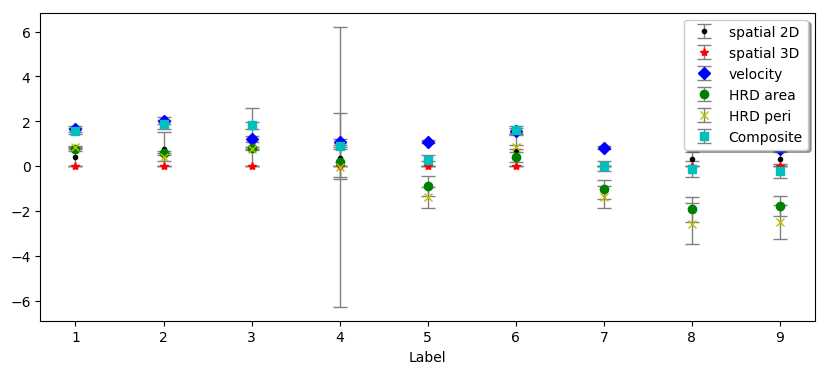

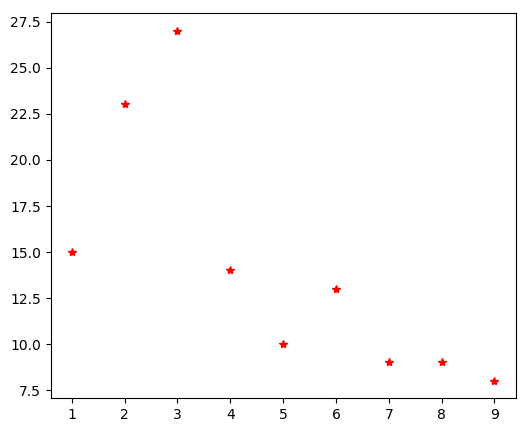

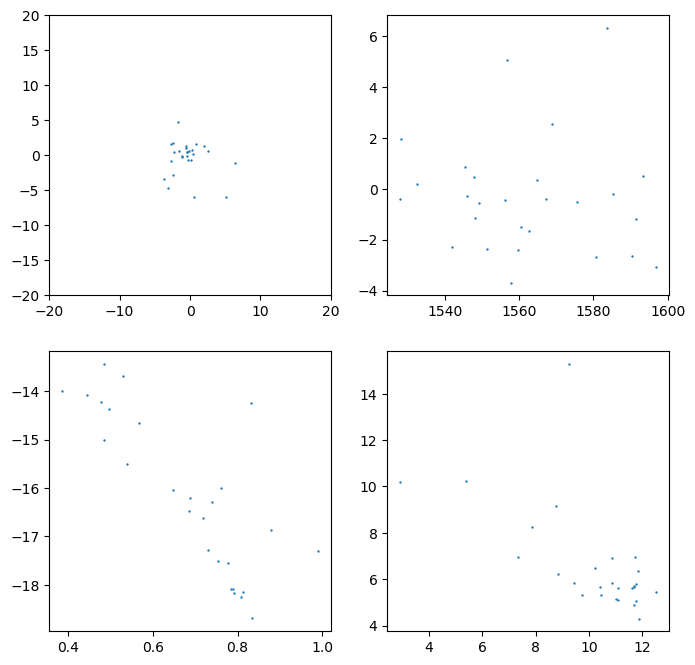

In [20]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 4.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.figure(figsize=(6.0,5.0))
plt.plot(xlabel, npts,"*r")
plt.show()


plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-20,20] , ylim = [-20,20])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()